In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
collisions = pd.read_csv("/content/drive/My Drive/MIE368 Project - Group 15/Code/collisions_dataset/collisions_dataset_new/collisions_enriched.csv")
speed_cameras = pd.read_csv("/content/drive/My Drive/MIE368 Project - Group 15/Code/speed_camera_dataset/speed_camera_clean_new/speed_cameras_clean.csv")

In [ ]:
print("Collisions data:")
print(collisions.head())

print("\nSpeed cameras data:")
print(speed_cameras.head())

Collisions data:
         date  hour        dow        lat        lon              severity  \
0  2014-01-01    17  Wednesday  43.701225 -79.377616  Property Damage Only   
1  2014-01-01    14  Wednesday  43.726091 -79.397589  Property Damage Only   
2  2014-01-01     4  Wednesday  43.762676 -79.336644  Property Damage Only   
3  2014-01-01    11  Wednesday  43.703234 -79.346615  Property Damage Only   
4  2014-01-01     1  Wednesday  43.650410 -79.378428  Property Damage Only   

   wx_precip_day  wx_precipitation  wx_rain  wx_snow  ...  \
0              0               0.0      0.0      0.0  ...   
1              0               0.0      0.0      0.0  ...   
2              0               0.0      0.0      0.0  ...   
3              0               0.0      0.0      0.0  ...   
4              0               0.0      0.0      0.0  ...   

   wx_avg_hourly_wind_speed  wx_max_relative_humidity  \
0                     19.38                      75.0   
1                     19.38      

In [ ]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# convert date to datetime
collisions['date'] = pd.to_datetime(collisions['date'], errors='coerce')

# group by date to get daily total collisions and average weather values
daily_data = (
    collisions.groupby('date').agg({'severity': 'count', 'wx_precip_amount_any': 'mean','wx_snow': 'mean'})
    .rename(columns={'severity': 'collision_count'})
    .reset_index()
)
print("Daily collision-weather summary:\n", daily_data.head())

Daily collision-weather summary:
         date  collision_count  wx_precip_amount_any  wx_snow
0 2014-01-01               55                   0.0      0.0
1 2014-01-02              140                   1.0      1.0
2 2014-01-03              218                   0.0      0.0
3 2014-01-04              137                   0.4      0.4
4 2014-01-05               92                  14.4     11.6


In [ ]:
# drop missing values
daily_data = daily_data.dropna(subset=['wx_precip_amount_any', 'wx_snow', 'collision_count'])

# compute pearson correlation coefficients
corr_precip, p_precip = stats.pearsonr(daily_data['wx_precip_amount_any'], daily_data['collision_count'])
corr_snow, p_snow = stats.pearsonr(daily_data['wx_snow'], daily_data['collision_count'])

print(f"Precipitation vs Collisions: r = {corr_precip:.3f}, p = {p_precip:.6f}")
print(f"Snow vs Collisions: r = {corr_snow:.3f}, p = {p_snow:.6f}")

Precipitation vs Collisions: r = 0.123, p = 0.000000
Snow vs Collisions: r = 0.217, p = 0.000000


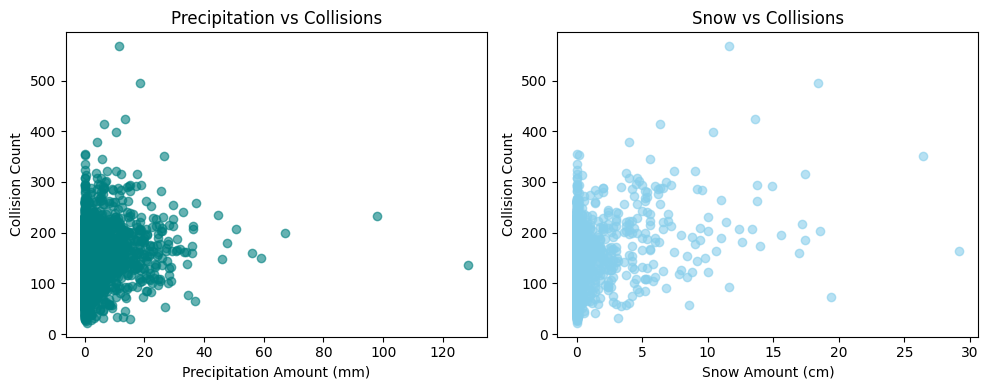

In [ ]:
plt.figure(figsize=(10,4))

# plot precipitation
plt.subplot(1,2,1)
plt.scatter(daily_data['wx_precip_amount_any'], daily_data['collision_count'], alpha=0.6, color='teal')
plt.xlabel("Precipitation Amount (mm)")
plt.ylabel("Collision Count")
plt.title("Precipitation vs Collisions")

# plot snow
plt.subplot(1,2,2)
plt.scatter(daily_data['wx_snow'], daily_data['collision_count'], alpha=0.6, color='skyblue')
plt.xlabel("Snow Amount (cm)")
plt.ylabel("Collision Count")
plt.title("Snow vs Collisions")

plt.tight_layout()
plt.show()

Severity levels:
 severity_num
1    554669
2     91778
Name: count, dtype: int64

T-Test: Severity Near vs Far Cameras
t = 1.8444, p = 6.514570e-02
No significant difference in severity between near and far collisions.


/tmp/ipython-input-2951418740.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='camera_near', y='severity_num', data=collisions, palette='Set2')


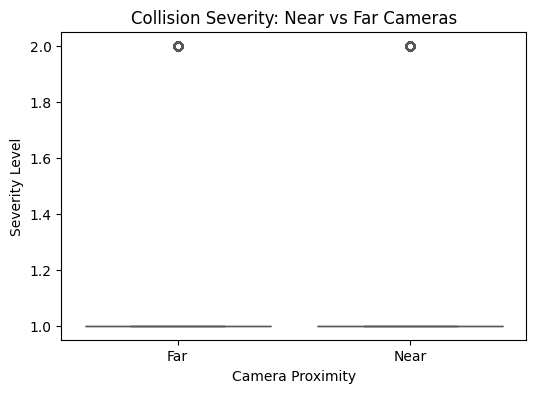


Chi-Square Test: Severity vs Camera Presence
Chi2 = 8.9443, p = 2.783333e-03
Severity distribution depends on camera presence.

Chi-Square Test: Lighting vs Severity
Chi2 = 554.4551, p = 1.351574e-122
Lighting conditions significantly influence severity.


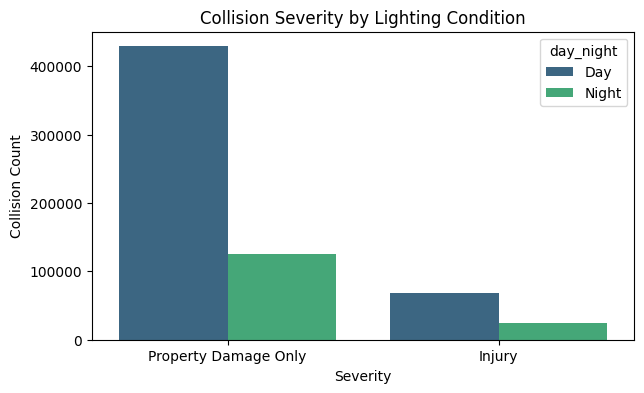


ANOVA: Collision Severity Across Months
F = 13.5216, p = 2.811059e-26
Mean severity differs significantly between months.


/tmp/ipython-input-2951418740.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='severity_num', data=collisions, palette='coolwarm')


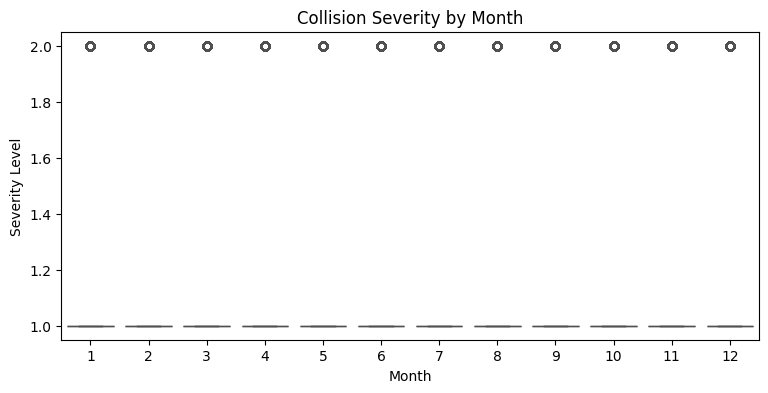

In [ ]:

# Statistical Tests

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prep columns
collisions['camera_near'] = collisions['cam_within_250m'].apply(lambda x: 'Near' if x == 1 else 'Far')
collisions['day_night'] = collisions['hour'].apply(lambda h: 'Day' if 7 <= h <= 18 else 'Night')

# Numeric mapping for severity
collisions['severity_num'] = collisions['severity'].map({
    'Property Damage Only': 1,
    'Injury': 2,
    'Non-Fatal Injury': 2,
    'Fatal': 3
})

print("Severity levels:\n", collisions['severity_num'].value_counts(dropna=False))



# T-Test: Near vs Far Cameras

near = collisions.loc[collisions['camera_near'] == 'Near', 'severity_num'].dropna()
far = collisions.loc[collisions['camera_near'] == 'Far', 'severity_num'].dropna()

# Balance sample sizes to avoid overpowering and numeric underflow
n = min(len(near), len(far), 10000)
near_s = near.sample(n, random_state=42)
far_s = far.sample(n, random_state=42)

t_stat, p_val = stats.ttest_ind(near_s, far_s, equal_var=False)
print("\nT-Test: Severity Near vs Far Cameras")
print(f"t = {t_stat:.4f}, p = {p_val:.6e}")
if p_val < 0.05:
    print("Significant difference in severity between near and far collisions.")
else:
    print("No significant difference in severity between near and far collisions.")

plt.figure(figsize=(6,4))
sns.boxplot(x='camera_near', y='severity_num', data=collisions, palette='Set2')
plt.title("Collision Severity: Near vs Far Cameras")
plt.xlabel("Camera Proximity")
plt.ylabel("Severity Level")
plt.show()



# Chi-Square Tests

# a) Severity vs Camera Presence
contingency1 = pd.crosstab(collisions['severity'], collisions['camera_near'])
chi2_1, p1, dof1, exp1 = stats.chi2_contingency(contingency1)
print("\nChi-Square Test: Severity vs Camera Presence")
print(f"Chi2 = {chi2_1:.4f}, p = {p1:.6e}")
if p1 < 0.05:
    print("Severity distribution depends on camera presence.")
else:
    print("No significant relationship between severity and camera presence.")

# b) Lighting (Day/Night) vs Severity
contingency2 = pd.crosstab(collisions['day_night'], collisions['severity'])
chi2_2, p2, dof2, exp2 = stats.chi2_contingency(contingency2)
print("\nChi-Square Test: Lighting vs Severity")
print(f"Chi2 = {chi2_2:.4f}, p = {p2:.6e}")
if p2 < 0.05:
    print("Lighting conditions significantly influence severity.")
else:
    print("No significant relationship between lighting and severity.")

plt.figure(figsize=(7,4))
sns.countplot(x='severity', hue='day_night', data=collisions, palette='viridis')
plt.title("Collision Severity by Lighting Condition")
plt.xlabel("Severity")
plt.ylabel("Collision Count")
plt.show()


# ANOVA: Compare Mean Severity Across Months

collisions['date'] = pd.to_datetime(collisions['date'], errors='coerce')
collisions['month'] = collisions['date'].dt.month

# group by month and sample equally
anova_groups = []
for m, group in collisions.groupby('month'):
    if group['severity_num'].nunique() > 1:
        sample = group['severity_num'].sample(min(len(group), 10000), random_state=42)
        anova_groups.append(sample)

print("\nANOVA: Collision Severity Across Months")
if len(anova_groups) > 1:
    f_stat, p_anova = stats.f_oneway(*anova_groups)
    print(f"F = {f_stat:.4f}, p = {p_anova:.6e}")
    if p_anova < 0.05:
        print("Mean severity differs significantly between months.")
    else:
        print("No significant difference in mean severity across months.")
else:
    print("Not enough variable groups — ANOVA cannot be computed.")

plt.figure(figsize=(9,4))
sns.boxplot(x='month', y='severity_num', data=collisions, palette='coolwarm')
plt.title("Collision Severity by Month")
plt.xlabel("Month")
plt.ylabel("Severity Level")
plt.show()
